In [1]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import pyro
import pyro.distributions as dist

## Probabilistic Programming

A probabilistic model is all of the following

    1. a "statistical-framework" which generates events based on one or more statistical assumptions.
    2. a web of causes-and-effects connected by probability-distributions that is used to explain reality.
    3. an event generator that can give non-determinate values based on a function of one or more probability-distributions


##### E.g.

To explain the behaviour of a _fair_ 6 sided dice, the following is a reasonable probabilistic-model:

    a random number generator between ${1,2,3,4,5,6}$, i.e., a uniform distribution of sample-space 1-6. 

Traffic in a city could be modelled as:
    
    Every household contains a car modeled with a binomial distribution of n=4 and p=0.15
    Every household contains a bike with p = 0.4 (Bernoulli Distribution)
    Each vehicle leaves onto the road in the morning between 8-12 with a poission distribution of lambda 1
    Every vehicle left will start back to home between 5pm-12pm with a probability following uniform distribution
    
    Probability of a vechicle choosing a destination is modeled by a PDF in 2-d plane (e.g., economic and industrial zones have a high probability) that is unique to the city geography
    
As you can see, a probabilistic model can contain multiple smaller probability models based on the complexity at hand.

A probabilistic programming language (PPL) is a language that can capture the complexity of probabilistic models.



### Sampling and Distributions

Two of the fundamental blocks of PPL are distributions and samplers.

We can combine `pyro.sample` and `pryo.distribution.Distribution` to obtain powerful apis for sample generators

```python
import pyro
import pyro.Distribution and dist

pyro.sample('x', dist.Normal(0, 1)) # return's a random value from normal distribution

def weather(cloudy=None):
    ...
        cloudy = pyro.sample('cloudy', dist.Bernoulli(1/3)) # return's 0/1 with p = 1/3 for cloudy
        ...
    ...
    temp = pyro.sample('temp', dist.Normal(mean_temp, scale_temp))
    ...
```

Below, let us simulate weather of a hypothetical place where it's cloudy $1/3^{rd}$ of the time. When it's cloudy, the temperature follows a normal distribution with mean 55.0 and std 10.0. If it's not cloudy the temperature seems to vary around 75.0 with std 15.0  
For convenience let's just assume a year has 300 days

Text(0.5,1,'Overcast')

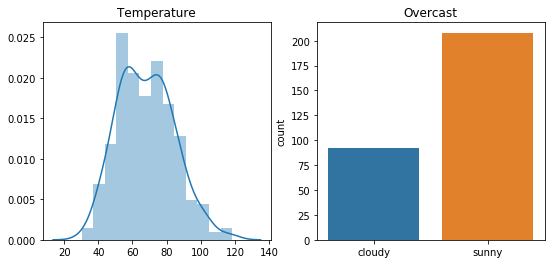

In [79]:

def weather(cloudy=None):
    if cloudy is None:
        cloudy = pyro.sample('cloudy', dist.Bernoulli(1/3)) # p = 1/3 for cloudy
        cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', dist.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

weathers = []
for _ in range(300):
    weathers.append(weather())
    
overcast, temp = zip(*weathers)

_, plts = plt.subplots(1, 2, figsize=(9, 4))
sns.distplot(temp, ax=plts[0]); plts[0].set_title('Temperature')
sns.countplot(overcast, ax=plts[1]); plts[1].set_title('Overcast')

Above we plotted _how_ the temperature would look given the assumptions. Note that We basically created a joint distribution of 'Cloudy' and 'Temperature' for the whole year in the form of list `weathers`

Once a model is set, we could call it as many times as we want

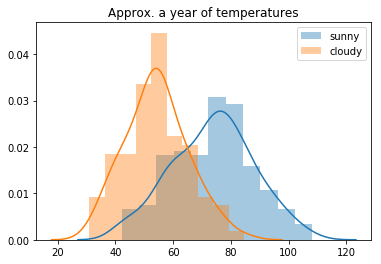

Text(0.5,1,'All observations combined')

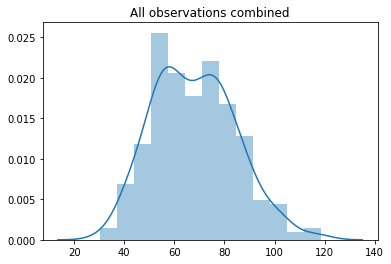

In [80]:
def temps(n=10, cloudy=None):
    n = int(n)
    return torch.tensor([weather(cloudy)[1] for _ in range(n)])

def expt(cloudydays, sunnydays):
    sunnydays = temps(sunnydays, 'sunny').numpy()
    cloudydays = temps(cloudydays, 'cloudy').numpy()
    return sunnydays, cloudydays

s, c = expt(100, 200)
sns.distplot(s, label='sunny')
sns.distplot(c, label='cloudy'); 
plt.title('Approx. a year of temperatures'); plt.legend(); plt.show()
sns.distplot(temp).set_title('All observations combined')

Text(0.5,1,'A Million observations')

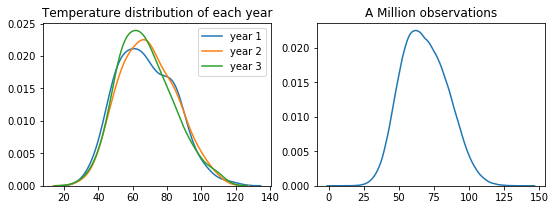

In [73]:
def expts(nc, ns, nexp):
    temps = [np.concatenate(expt(nc, ns)) for _ in range(nexp)]
    return temps

fig, plts = plt.subplots(1, 2, figsize=(9,3))
yearly_temps = expts(100, 200, 3)
for yearno, yeartemps in enumerate(yearly_temps):
    sns.distplot(yeartemps, hist=False, label=f'year {yearno+1}', ax=plts[0])
plts[0].set_title('Temperature distribution of each year')

temps1M = temps(n=1e6)
sns.distplot(temps1M, hist=False).set_title('A Million observations')

#### Side Note: Moar Distributions!!

pyro has a whole suite of standard distributions one could use to model

In [3]:
dir(dist)[:38]

['Bernoulli',
 'Beta',
 'Binomial',
 'Categorical',
 'Cauchy',
 'Chi2',
 'Delta',
 'Dirichlet',
 'Distribution',
 'Empirical',
 'Exponential',
 'ExponentialFamily',
 'FisherSnedecor',
 'Gamma',
 'Geometric',
 'Gumbel',
 'HalfCauchy',
 'HalfNormal',
 'Independent',
 'InverseAutoregressiveFlow',
 'Laplace',
 'LogNormal',
 'LogisticNormal',
 'LowRankMultivariateNormal',
 'Multinomial',
 'MultivariateNormal',
 'Normal',
 'OMTMultivariateNormal',
 'OneHotCategorical',
 'Pareto',
 'Poisson',
 'Rejector',
 'RelaxedBernoulli',
 'RelaxedOneHotCategorical',
 'StudentT',
 'TorchDistribution',
 'TransformedDistribution',
 'Uniform']

#### Exercises for the reader
1. Create a normal distribution
2. Create a distribution which is the product of two normal distributions
3. Return a distribution which samples from a normal distribution whose mean is in turn sampled from another distribution

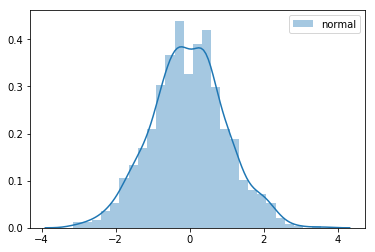

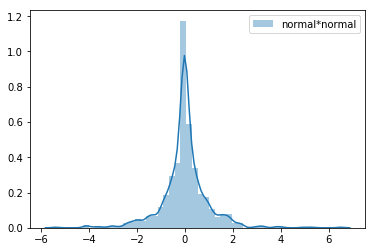

Text(0.5,1,'Normal (Normal (0, 1), 1)')

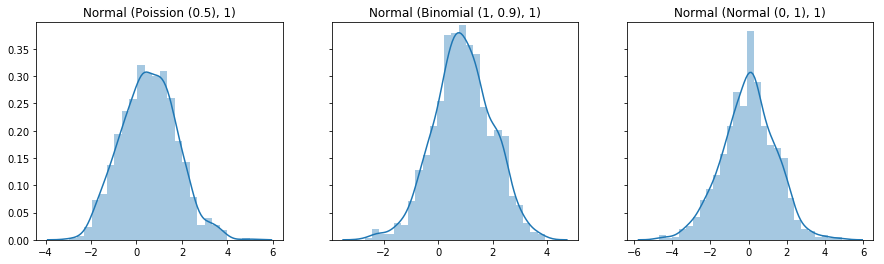

In [30]:
sns.distplot([pyro.sample('x', dist.Normal(0, 1)) for _ in range(1000)], label='normal')
plt.legend(); plt.show()

def normal_normal(loc, scale):
    z1 = pyro.sample("z1", dist.Normal(loc, scale))
    z2 = pyro.sample("z2", dist.Normal(loc, scale))
    y = z1 * z2
    return y

sns.distplot([normal_normal(0, 1) for _ in range(1000)], label='normal*normal')
plt.legend(); plt.show()

def make_dist_normal(distribution):
    mu_latent = pyro.sample("mu_latent", distribution)
    x = pyro.sample('x', dist.Normal(mu_latent.item(), 1))
    return x.item()

_, plts = plt.subplots(1, 3, figsize=(15,4), sharey=True)

dist1 = dist.Poisson(0.5)
sns.distplot([make_dist_normal(dist1) for _ in range(1000)], ax=plts[0]).set_title('Normal (Poission (0.5), 1)')

dist2 = dist.Binomial(1, probs=torch.tensor([0.9]))
sns.distplot([make_dist_normal(dist2) for _ in range(1000)], ax=plts[1]).set_title('Normal (Binomial (1, 0.9), 1)')

dist3 = dist.Normal(0, 1)
sns.distplot([make_dist_normal(dist3) for _ in range(1000)], ax=plts[2]).set_title('Normal (Normal (0, 1), 1)')


### Inferences

In [32]:
from pyro import infer
from pyro import optim

#### Knobs and Levers

In [33]:
# a random sampler from normal-distribution
rnorm = lambda: pyro.sample('x', dist.Normal(0, 1))

# a posterior that is going to store `num_samples` observations when `run`.
# it also stores all the paths that lead to the generation of all such samples
posterior = infer.Importance(rnorm, num_samples=100)
posterior.run()

In [35]:
marginal = infer.EmpiricalMarginal(posterior)
print(marginal())# returns a sample from the observed distribution `d`
# repeated calls would return observations from the same `d`
[marginal() for _ in range(10)]
# since `num_samples` is two we'd see the same two results repeated

tensor(0.2948)


[tensor(0.2948),
 tensor(0.5687),
 tensor(-1.6443),
 tensor(-1.0310),
 tensor(-1.2247),
 tensor(0.0488),
 tensor(-0.4995),
 tensor(-1.5287),
 tensor(0.2397),
 tensor(0.4505)]

#### Problem: Unreliable Scale

In [300]:
def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    # the measurement fluctuates around the true weight
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

posterior = infer.Importance(scale, num_samples=100)
guess = 8.5
marginal = infer.EmpiricalMarginal(posterior.run(guess))
print(marginal())

tensor(7.6641)


In [286]:

conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})
# We've observed the scale is showing the weight as 9.5
# We are still unsure of what the actual weight is

# since we've conditioned on the final output, the function gives the same result
# no matter what `guess` you might give
rand = lambda : np.random.rand()*10 # rng between 0 and 10
print([conditioned_scale(rand()) for _ in range(10)])

8.08170545205832
[9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5]


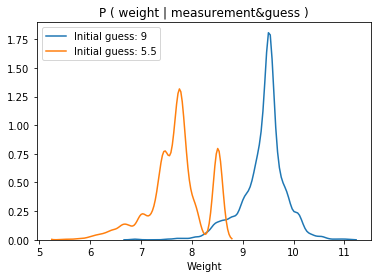

In [335]:
guess1 = 9
guess2 = 5.5
measurement = 9.5
nobs = 1000

def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    tolerance = pyro.sample("tolerance", dist.Uniform(0., 1.))
    return pyro.sample("measurement", dist.Normal(weight, tolerance))

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})

marginal1 = pyro.infer.EmpiricalMarginal(
    pyro.infer.Importance(conditioned_scale, num_samples=nobs).run(guess1),
    sites="weight")
# The marginal distribution concentrates around the data
sns.distplot([marginal1().item() for _ in range(nobs)], hist=False, label=f'Initial guess: {guess1}')

marginal2 = pyro.infer.EmpiricalMarginal(
    pyro.infer.Importance(conditioned_scale, num_samples=nobs).run(guess2),
    sites="weight")
sns.distplot([marginal2().item() for _ in range(nobs)], hist=False, label=f'Initial guess: {guess2}')

plt.title('P ( weight | measurement&guess )')
plt.xlabel('Weight')
plt.legend()


above plot suggests,   
`if your guess is 5.5 and the scale measures a 9.5 then most probably the actual weight is ~8`  
`if your guess is 9 and the scale measures a 9.5 then most probably the actual weight is ~9.5`

We have experimented 1000 times with each guess, i.e., 
we collect 1000 different objects that *we think* are 5.5 kg and when we measured it, the weight always turned out to be 9.5
1. Each experiement is independent of the past in this case
2. For some reason scale is always measuring 9.5
Neither of these are normal things in reality

But we can reinterpret both the problems as following. In fact, we _should_, because the interpretation will be consistent with what we did.  

We took an object and I guessed it might be 5.5 kg.  
You say it is "probably 9 kg or whatever". 

I went and measured the object's weight and it turned out be 9.5 by some crude measurement hueristic (say displacing water and measuring volume of water which in turn gave weight as 9.5 kg, aka, the observation). Now, that is the **only** data point we have. Can we tell _anything_ about the _actual_ weight of the thing? i.e., if we could measure with a high caliberated weight scale?

```
 1) If we stick to our individual hypotheses   
 
and

 2) if the measurement (measured in the same crude way) 1000 times always turned out to be 9.5,   
 
then

 taking all random variation into account we could say that  
 a) in my hypothesis the weight of the stone is mostly an 8  
 b) and in your hypothesis it is probably 9.5
```
And since observation turned out closer to your expectation of mean than mine, you hypothesis is more likely to be correct

```python
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    tolerance = torch.abs(pyro.sample("tolerance", dist.Normal(0., 1.)))
    return pyro.sample("measurement", dist.Normal(weight, tolerance))
```
We are making the following assumptions when we use _this_ kind of scale
1. Somehow our guesses are connected to the _real world_ weights of an object. 
> In fact, the dependence follows a normal distribution, i.e., when _anyone_ takes a wild guess about weight of an object, we are merely assuming the actual weight would be 1 standard deviation away from the guess ~67% of the times.
2. Tolerance of the experiment apparatus is unknown, but we can say the standard deviation is somewhere between 0 and 1 kg
3. Machine reads a weight taking into account the `tolerance` amount of noise
All the assumptions debatable, and more imporantly _clear_. This is an important and integral part in the scientific method.

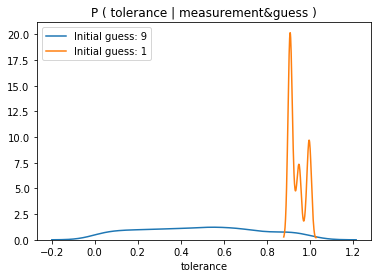

In [337]:
guess1 = 9
guess2 = 1
measurement = 9.5
nobs = 1000

def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    tolerance = pyro.sample("tolerance", dist.Uniform(0., 1.))
    return pyro.sample("measurement", dist.Normal(weight, tolerance))

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})


marginal1 = pyro.infer.EmpiricalMarginal(
    pyro.infer.Importance(conditioned_scale, num_samples=nobs).run(guess1),
    sites="tolerance")
# The marginal distribution concentrates around the data
sns.distplot([marginal1().item() for _ in range(nobs)], hist=False, label=f'Initial guess: {guess1}')

marginal2 = pyro.infer.EmpiricalMarginal(
    pyro.infer.Importance(conditioned_scale, num_samples=nobs).run(guess2),
    sites="tolerance")
sns.distplot([marginal2().item() for _ in range(nobs)], hist=False, label=f'Initial guess: {guess2}')

plt.title('P ( tolerance | measurement&guess )')
plt.xlabel('tolerance')
plt.legend()

It says, given these observations (i.e., conditioned on these observations),
It is highly likely that the machine's tolerance is _very high_ in guess 1 as compared to guess 2.

Again, this means my hypothesis is more unlikely because the machine's tolerance is not in line with my own assumption 2.   
In other words, 
> In case 1 - _only_ if the machine is _very_ faulty is it possible that an object is _actually_ 1 kg heavy but is being read as 9.5 kg  
> In case 2 - The object is actually 9 kg and because the machine is faulty to an extent it is being read as 9.5 kg

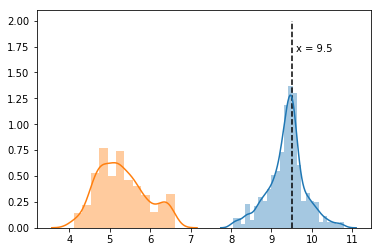

In [349]:
def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={"measurement": measurement})(*args, **kwargs)

def scale_posterior_guide(measurement, guess):
    # note that torch.size(measurement, 0) is the total number of measurements
    # that we're conditioning on
    a = (guess + torch.sum(measurement)) / (measurement.size(0) + 1.0)
    b = 1. / (measurement.size(0) + 1.0)
    return pyro.sample("weight", dist.Normal(a, b))

posterior = pyro.infer.Importance(deferred_conditioned_scale,
                                  guide=scale_posterior_guide,
                                  num_samples=nobs)
# now we are suggesting, how weight could be connected by measurement and guess, i.e.,
# a beta distribution of 1 prior and n-1 measurements

marginal1 = pyro.infer.EmpiricalMarginal(posterior.run(torch.tensor([measurement]), guess1), sites="weight")
sns.distplot([marginal1().item() for _ in range(nobs//2)])

marginal1 = pyro.infer.EmpiricalMarginal(posterior.run(torch.tensor([measurement]), guess2), sites="weight")
g = sns.distplot([marginal1().item() for _ in range(nobs//2)])

g.vlines(9.5, 0, 2, linestyles='dashed')
g.text(9.6, 1.7, 'x = 9.5')

#### Problem: M&M

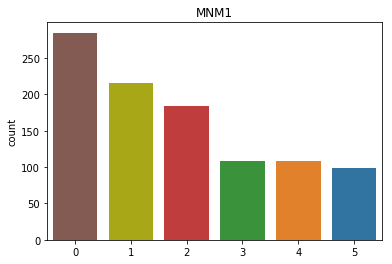

Text(0.5,1,'MNM2')

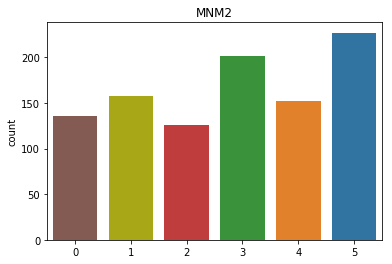

In [277]:
'''
 The M&M problem

In 1995, they introduced blue M&M’s.  Before then, the color mix in a bag
of plain M&M’s was 30% Brown,  20% Yellow,  20% Red,  10% Green,  10%
Orange,  10% Blue.   Afterward it was 13% Brown, 14% Yellow, 13% Red, 
20% Green,16% Orange,24% Blue.'''
colorpalette = {lvl:clr for lvl,clr in enumerate(['tab:brown','y','tab:red','tab:green','tab:orange','tab:blue'])}

mnms1 = dist.Multinomial(probs=torch.tensor([0.30, 0.20, 0.20, 0.1, 0.10, 0.10]))
mnms2 = dist.Multinomial(probs=torch.tensor([0.13, 0.14, 0.13, 0.2, 0.16, 0.24]))

sns.countplot([pyro.sample('mnm1', mnms1).argmax().item() for _ in range(1000)], palette=colorpalette).set_title('MNM1'); plt.show()
sns.countplot([pyro.sample('mnm2', mnms2).argmax().item() for _ in range(1000)], palette=colorpalette).set_title('MNM2')

In [ ]:
'''
Suppose a friend of mine has two bags of M&M’s, and he tells me that one
is from 1994 and one from 1996.  He won’t tell me which is which, but he
gives me one M&M from each bag. One is yellow and one is green. What is
the probability that the yellow one came from the 1994 bag?'''
